In [1]:
import os
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
import pandas as pd
import seaborn as sn
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn import preprocessing

In [2]:
folder_dataset = 'data/images'
seed = 2704
features = ['dist', 'extent', 'slope', 'pwp_limit', 'pwp_middle']

In [3]:
files = [file for file in os.listdir(folder_dataset) if file.endswith('.jpg')]
len(files)

1180

In [4]:
def load_image(img_name):
    img = cv.imread(os.path.join(folder_dataset, img_name))
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    return img

def process_image(img, clahe_tile=(19,19), kernel_size=(37,37)):
    # Preprocess
    #smoothed = cv.blur(img,(5,5))
    denoise = cv.fastNlMeansDenoising(img,None,21,7)
    # Convert to gray
    img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    # CLAHE
    clahe_filter = cv.createCLAHE(clipLimit=3,tileGridSize=clahe_tile)
    clahe = clahe_filter.apply(img_gray)
    #clahe = cv.equalizeHist(img_gray)
    # Otsu
    _, otsu = cv.threshold(clahe,0,255,cv.THRESH_BINARY_INV+cv.THRESH_OTSU)
    # Closing (Dilate+Erode)
    kernel = np.ones(kernel_size,np.uint8)
    closing = cv.morphologyEx(otsu, cv.MORPH_OPEN, kernel)
    # Fill holes    
    holes = closing.copy()
    contours,_ = cv.findContours(holes,cv.RETR_CCOMP,cv.CHAIN_APPROX_SIMPLE)
    limit = img.shape[0]*img.shape[1]*0.05
    for contour in contours:
        area = cv.contourArea(contour)
        if area<limit:
            cv.drawContours(holes,[contour],0,0, thickness=cv.FILLED)
    return [img,denoise,clahe,otsu,closing,holes]

In [5]:
def percentage_white_pixels(image, height):
    img_cut1 = image[0:height+1,:]
    total_pixels_section = img_cut1.shape[0]*img_cut1.shape[1]
    pixels1 = np.count_nonzero(img_cut1 == 255)
    pwp1 = (pixels1*100)/total_pixels_section
    
    img_cut2 = image[height:image.shape[0],:]
    total_pixels_section = img_cut2.shape[0]*img_cut2.shape[1]
    pixels2= np.count_nonzero(img_cut2 == 255)
    pwp2 = (pixels2*100)/total_pixels_section
    return [pwp1, pwp2, pixels1, pixels2]

def cut_section(image, return_process=False, calculate_features=False):
    contours,_ = cv.findContours(image,cv.RETR_CCOMP,cv.CHAIN_APPROX_SIMPLE)
    img = cv.cvtColor(image,cv.COLOR_GRAY2RGB)
    biggest_contour = []
    biggest_area = 0
    final_data = {}
    for contour in contours:
        area = cv.contourArea(contour)
        if area>biggest_area:
            biggest_contour = contour
            biggest_area = area
    if biggest_area>0:        
        rows,cols = img.shape[:2]
        
        min_col0 = rows
        max_col0 = 0
        min_cols = rows
        max_cols = 0
        contour = []
        for point in biggest_contour:
            if point[0][0]==0:
                if point[0][1]> max_col0:
                    max_col0 = point[0][1]
                if point[0][1]< min_col0:
                    min_col0 = point[0][1]
            if point[0][0]==(cols-1):
                if point[0][1]> max_cols:
                    max_cols = point[0][1]
                if point[0][1]< min_cols:
                    min_cols = point[0][1]
            contour.append([point[0][0], point[0][1]])
        final_data['biggest_contour'] = contour
        
        diff_ymax = abs(rows-max_col0)
        if diff_ymax>min_col0:
            y_value = max_col0
        else:
            y_value = min_col0
        if y_value<image.shape[0] and y_value>0:
            pwp1, pwp2, _, _ = percentage_white_pixels(image, int(y_value))        
            if pwp1>pwp2:
                final_data['sign'] = 1
                begin_point = [0,max_col0]
                end_point = [cols-1,max_cols]
            else: 
                final_data['sign'] = -1
                begin_point = [0,min_col0]
                end_point = [cols-1,min_cols]
            if begin_point in contour and end_point in contour:
                index_begin = contour.index(begin_point)
                index_end = contour.index(end_point)
                contour_line = contour[index_begin:index_end+1]
                if contour_line[1][0]==0:
                    contour_line = contour[index_end:] + contour[:index_begin+1]
                final_data['contour_line'] = contour_line

                min_line = begin_point[1]
                max_line = 0
                for point in contour_line:
                    if point[1]<min_line:
                        min_line = point[1]
                    if point[1]>max_line:
                        max_line = point[1]

                final_data['y1'] = min_line
                final_data['y2'] = max_line
                final_data['dist'] = max_line - min_line

                if return_process:
                    cv.rectangle(img,(0,min_line),(cols-1,max_line),(255,0,0),2)
        if return_process:
            if not calculate_features:
                cv.drawContours(img, [biggest_contour], 0, (0,255,0), 2)
            final_data['img'] = img            
    return final_data

def calculate_features(image, final_data, return_process=False):
    
    line_point = np.array(final_data['contour_line'] , dtype=np.int32)
    X = np.reshape(line_point[:,0], (len(line_point), -1))
    y = line_point[:,1]
    reg = LinearRegression().fit(X, y)
    final_data['slope'] = reg.coef_[0]

    middle = int((final_data['y1']+final_data['y2'])/2)
    validation = True
    if final_data['sign'] == 1:
        if (final_data['y2']+1)<image.shape[0]:
            _, _, pixels_limit ,  _= percentage_white_pixels(image, int(final_data['y2']+1))
            _, _, pixels_middle ,  _= percentage_white_pixels(image, int(middle+1))
        else:
            validation = False
    else:
        if final_data['y1']>0:
            _, _, _,  pixels_limit= percentage_white_pixels(image, int(final_data['y1']-1))
            _, _, _,  pixels_middle= percentage_white_pixels(image, int(middle-1))
        else:
            validation = False
    if validation:
        total_pixels = image.shape[0]*image.shape[1]
        final_data['pwp_limit']  =  pixels_limit/total_pixels
        final_data['pwp_middle']  = pixels_middle/total_pixels

        if final_data['sign'] == 1:
            beginning_point = [0,final_data['y1']]
            ending_point = [image.shape[1]-1,final_data['y1']]
        else:
            beginning_point = [0,final_data['y2']]
            ending_point = [image.shape[1]-1,final_data['y2']]

        if final_data['contour_line'][0][0] == 0:
            complete_contour = np.array([beginning_point] + final_data['contour_line'] + [ending_point], dtype=np.int32)
        else:
            complete_contour = np.array([ending_point] + final_data['contour_line'] + [beginning_point], dtype=np.int32)

        area = cv.contourArea(complete_contour)
        x,y,w,h = cv.boundingRect(complete_contour)
        rect_area = w*h
        extent = float(area)/rect_area
        final_data['extent'] = extent       

        if return_process:
            cv.drawContours(final_data['img'], [complete_contour], 0, (0,255,0), 2)
            cv.rectangle(final_data['img'],(x,y),(x+w,y+h),(255,0,0),2)

In [6]:
def cut_image(image, y1, y2):
    y1 = y1-50
    y1 = 0 if y1<0 else y1
    y2 = y2+50
    y2 = (image.shape[0]-1) if y2>(image.shape[0]-1) else y2
    return image[y1:y2,:]

def show_process(imgs):
    fig, axs = plt.subplots(1, 7, figsize=(16,5)) 
    axs[0].imshow(imgs[0])
    axs[0].axis('off')
    axs[0].set_title('(a) Original')
    axs[1].imshow(imgs[1])
    axs[1].axis('off')
    axs[1].set_title('(b) Preprocess')
    axs[2].imshow(imgs[2], cmap='gray')
    axs[2].axis('off')
    axs[2].set_title('(c) Gray and CLAHE')
    axs[3].imshow(imgs[3], cmap='gray')
    axs[3].axis('off')
    axs[3].set_title('(d) Otsu')
    axs[4].imshow(imgs[4], cmap='gray')
    axs[4].axis('off')
    axs[4].set_title('(e) Closing')
    axs[5].imshow(imgs[5], cmap='gray')
    axs[5].axis('off')
    axs[5].set_title('(f) Fill holes')
    axs[6].imshow(imgs[6])
    axs[6].axis('off')
    axs[6].set_title('(g) Contour features')
    plt.show()
    
def save_process(imgs, file_name):
    cv.imwrite('data/process/'+file_name+'_0_original.jpg', cv.cvtColor(imgs[0], cv.COLOR_RGB2BGR))
    cv.imwrite('data/process/'+file_name+'_1_preprocess.jpg', cv.cvtColor(imgs[1], cv.COLOR_RGB2BGR))
    cv.imwrite('data/process/'+file_name+'_2_clahe.jpg', imgs[2])
    cv.imwrite('data/process/'+file_name+'_3_otsu.jpg', imgs[3])
    cv.imwrite('data/process/'+file_name+'_4_closing.jpg', imgs[4])
    cv.imwrite('data/process/'+file_name+'_5_holes.jpg', imgs[5])
    cv.imwrite('data/process/'+file_name+'_6_contours.jpg', cv.cvtColor(imgs[6], cv.COLOR_RGB2BGR))

# Examples of the process

Pieza_01_foto00_0.jpg


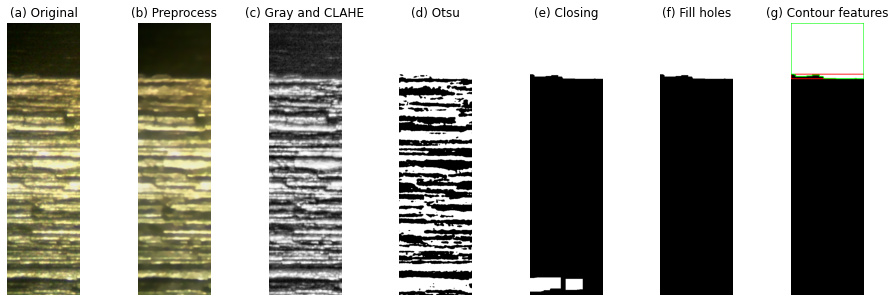

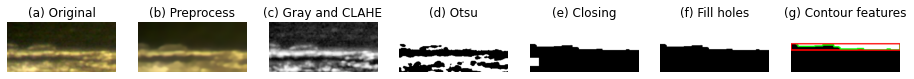

In [7]:
file = files[0]
print(file)

image = load_image(file)
img_process = process_image(image)
data_vector =  cut_section(img_process[-1], True)
img_process.append(data_vector['img'])
show_process(img_process)
save_process(img_process, file[:-4])

img_cut=image[data_vector['y1']-50:data_vector['y2']+50,:]
img_process_cut = process_image(img_cut, clahe_tile = (5,5), kernel_size=(17,39))
data_vector_cut =  cut_section(img_process_cut[-1], True, True)
calculate_features(img_process_cut[-1], data_vector_cut, True)
img_process_cut.append(data_vector_cut['img'])
show_process(img_process_cut)
save_process(img_process_cut, file[:-4]+'_section')

Pieza_01_foto0119_0.jpg


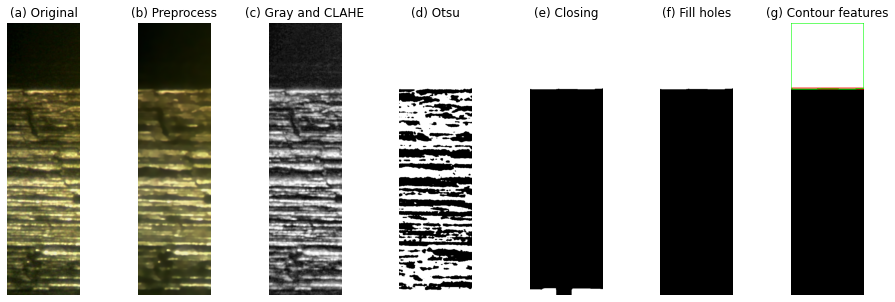

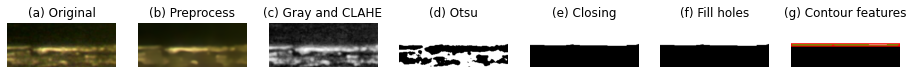

In [8]:
file = files[10]
print(file)

image = load_image(file)
img_process = process_image(image)
data_vector =  cut_section(img_process[-1], True)
img_process.append(data_vector['img'])
show_process(img_process)
save_process(img_process, file[:-4])

img_cut=image[data_vector['y1']-50:data_vector['y2']+50,:]
img_process_cut = process_image(img_cut, clahe_tile = (5,5), kernel_size=(17,39))
data_vector_cut =  cut_section(img_process_cut[-1], True, True)
calculate_features(img_process_cut[-1], data_vector_cut, True)
img_process_cut.append(data_vector_cut['img'])
show_process(img_process_cut)
save_process(img_process_cut, file[:-4]+'_section')

Pieza_01_foto0277_0.jpg


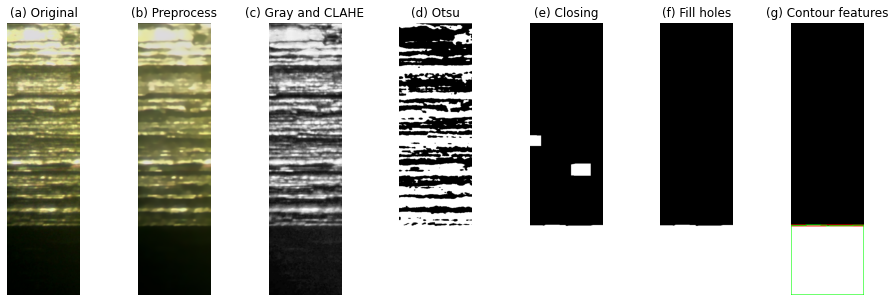

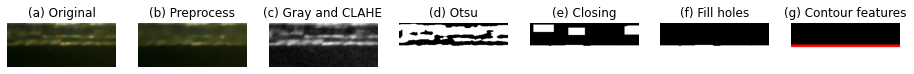

In [9]:
file = files[50]
print(file)

image = load_image(file)
img_process = process_image(image)
data_vector =  cut_section(img_process[-1], True)
img_process.append(data_vector['img'])
show_process(img_process)
save_process(img_process, file[:-4])

img_cut=image[data_vector['y1']-50:data_vector['y2']+50,:]
img_process_cut = process_image(img_cut, clahe_tile = (5,5), kernel_size=(17,39))
data_vector_cut =  cut_section(img_process_cut[-1], True, True)
calculate_features(img_process_cut[-1], data_vector_cut, True)
img_process_cut.append(data_vector_cut['img'])
show_process(img_process_cut)
save_process(img_process_cut, file[:-4]+'_section')

Pieza_01_foto369_0.jpg


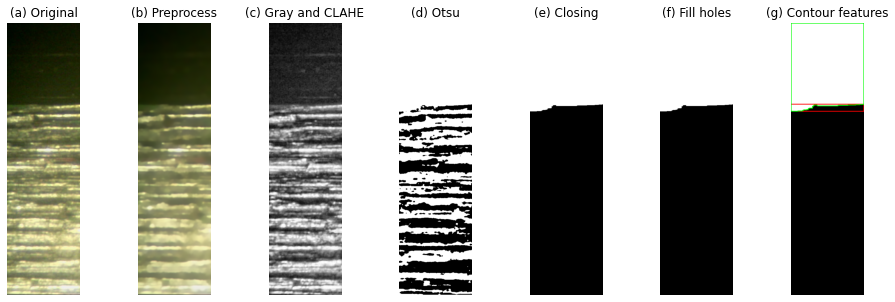

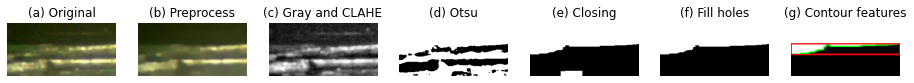

In [10]:
file = files[200]
print(file)

image = load_image(file)
img_process = process_image(image)
data_vector =  cut_section(img_process[-1], True)
img_process.append(data_vector['img'])
show_process(img_process)
save_process(img_process, file[:-4])

img_cut=image[data_vector['y1']-50:data_vector['y2']+50,:]
img_process_cut = process_image(img_cut, clahe_tile = (5,5), kernel_size=(17,39))
data_vector_cut =  cut_section(img_process_cut[-1], True, True)
calculate_features(img_process_cut[-1], data_vector_cut, True)
img_process_cut.append(data_vector_cut['img'])
show_process(img_process_cut)
save_process(img_process_cut, file[:-4]+'_section')

Pieza_02_foto066_0.jpg


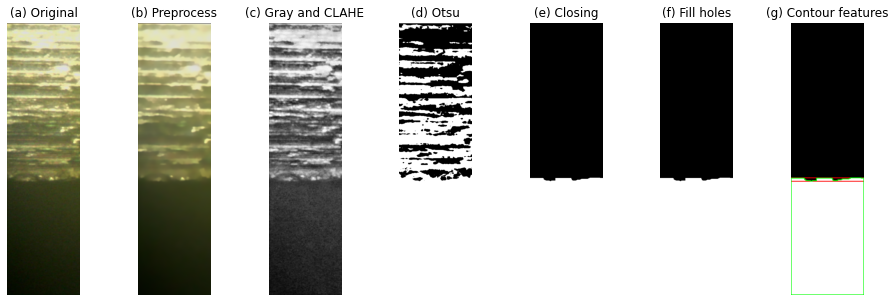

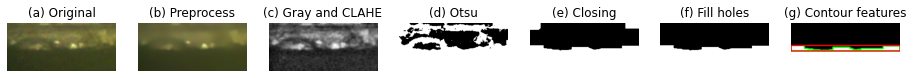

In [11]:
file = files[250]
print(file)

image = load_image(file)
img_process = process_image(image)
data_vector =  cut_section(img_process[-1], True)
img_process.append(data_vector['img'])
show_process(img_process)
save_process(img_process, file[:-4])

img_cut=image[data_vector['y1']-50:data_vector['y2']+50,:]
img_process_cut = process_image(img_cut, clahe_tile = (5,5), kernel_size=(17,39))
data_vector_cut =  cut_section(img_process_cut[-1], True, True)
calculate_features(img_process_cut[-1], data_vector_cut, True)
img_process_cut.append(data_vector_cut['img'])
show_process(img_process_cut)
save_process(img_process_cut, file[:-4]+'_section')

# Process images

In [12]:
data = pd.DataFrame(columns=['img_name', 'folder','image', 'section']+features)
for file in files:
    image = load_image(file)
    img_process = process_image(image)
    data_vector =  cut_section(img_process[-1])
    if "dist" in data_vector:  
        img_cut = cut_image(img_process[0],data_vector['y1'],data_vector['y2'])
        if img_cut.shape[0]>10:
            img_process_cut = process_image(img_cut, clahe_tile = (5,5), kernel_size=(17,39))            
            data_vector_cut =  cut_section(img_process_cut[-1], True, True)
            if "contour_line" in data_vector_cut:
                calculate_features(img_process_cut[-1], data_vector_cut, True)  
                if "extent" in data_vector_cut:
                    info = {'img_name': file[:-4],'folder': int(file[6:8]), 'image': int(file[13:-6]), 'section': int(file[-5:-4])}
                    for feature in features:
                        info[feature] = data_vector_cut[feature]
                    data = data.append(info, ignore_index=True)
data.to_csv('data/data.csv', index=False, sep=';', decimal=".")
data.head()

,img_name,folder,image,section,dist,extent,slope,pwp_limit,pwp_middle
0,Pieza_01_foto00_0,1,0,0,14,0.610938,0.056375,0.519026,0.495252
1,Pieza_01_foto00_1,1,0,1,4,0.325781,0.018356,0.501278,0.498649
2,Pieza_01_foto00_2,1,0,2,36,0.824852,0.105911,0.579906,0.481158
3,Pieza_01_foto00_3,1,0,3,4,0.547656,-0.004432,0.507075,0.504717
4,Pieza_01_foto00_4,1,0,4,8,0.542752,0.010188,0.494553,0.486991


In [13]:
data = pd.read_csv('data/data.csv', delimiter=';', decimal=".")
data_category = pd.read_csv('data/data_category.csv', delimiter=';', decimal=".")
data_category = data_category[data_category.category>0]
data = data_category.merge(data, left_on=['img_name','folder','image','section'], right_on=['img_name','folder','image','section'])
data.to_csv('data/data_final.csv', index=False, sep=';', decimal=".")

# Load final data

In [14]:
data = pd.read_csv('data/data_final.csv', delimiter=';', decimal=".")

In [15]:
data.describe()

,folder,image,section,category,dist,extent,slope,pwp_limit,pwp_middle
count,1073.000000,1073.000000,1073.000000,1073.000000,1073.000000,1073.000000,1073.000000,1073.000000,1073.000000
mean,5.820130,265.246971,1.988816,1.827586,17.984157,0.479272,-0.023983,0.480948,0.464789
std,4.149299,216.499155,1.408882,0.773333,32.029148,0.123328,0.152550,0.054263,0.056211
min,1.000000,0.000000,0.000000,1.000000,1.000000,0.162760,-1.398977,0.254200,0.220784
25%,3.000000,67.000000,1.000000,1.000000,5.000000,0.395221,-0.042798,0.460970,0.443729
50%,5.000000,219.000000,2.000000,2.000000,9.000000,0.473828,-0.008910,0.488169,0.477828
75%,10.000000,460.000000,3.000000,2.000000,20.000000,0.558203,0.006442,0.508422,0.496732
max,13.000000,774.000000,4.000000,3.000000,564.000000,0.930510,3.259540,0.686284,0.681722


In [16]:
data.loc[data['category'] ==1, 'category_type'] = 'K'
data.loc[data['category'] ==2, 'category_type'] = 'S'
data.loc[data['category'] ==3, 'category_type'] = 'B'

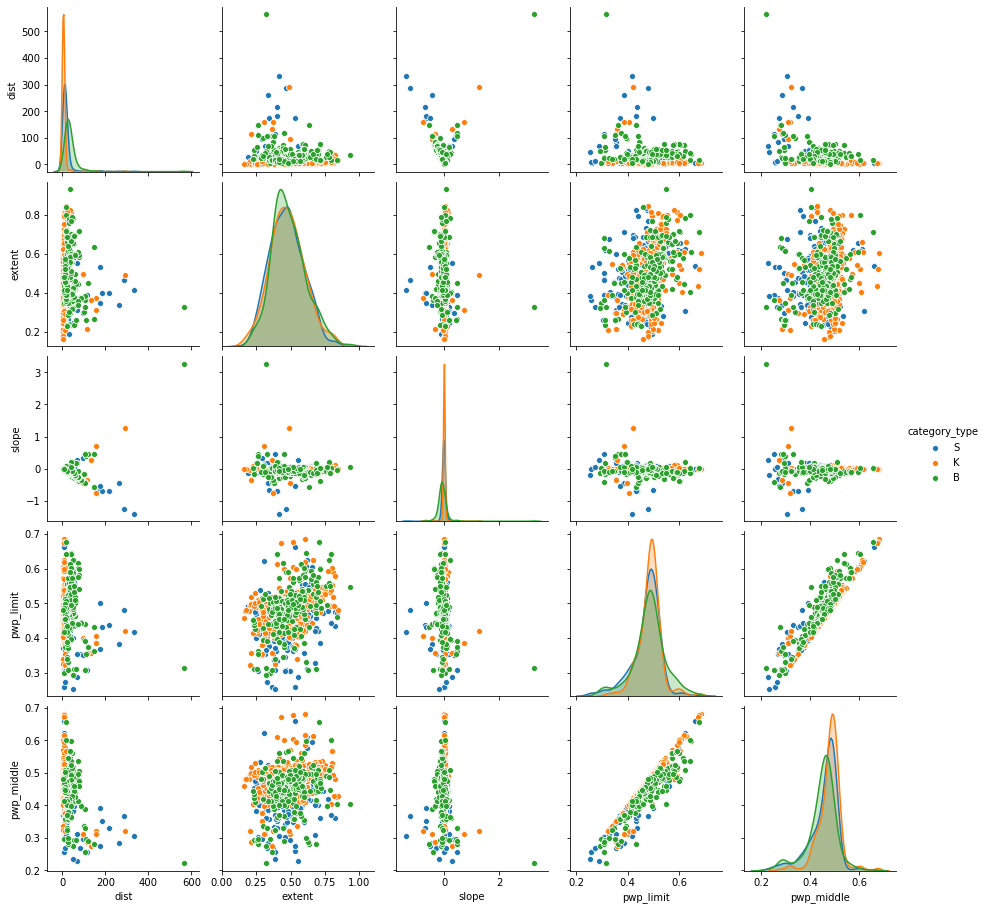

In [17]:
sn.pairplot(data, hue="category_type", vars=features, diag_kind="kde")
plt.savefig('pair_plot.jpg', dpi=200)

In [18]:
print(data.shape)
X_values = data[features]
y_values = data[['category']].values.ravel()

X_train, X_test, y_train, y_test = train_test_split(X_values, y_values, test_size=0.2, random_state=seed)

(1073, 11)


# Grid Search CV

In [19]:
models = [
            'ADB',
            'GBC',
            'RFC',
            'KNC'
         ]
clfs = [
        AdaBoostClassifier(random_state=seed),
        GradientBoostingClassifier(random_state=seed),
        RandomForestClassifier(random_state=seed,n_jobs=-1),
        KNeighborsClassifier(n_jobs=-1)
        ]
params = {
            models[0]: {'n_estimators':range(100,150,50)},
            models[1]: {'n_estimators':range(100,150,50), 'max_depth':range(5,9,2)},
            models[2]: {'criterion':['entropy'], 'n_estimators':range(85,100,10), 'max_depth':range(12,20,2)},
            models[3]: {'n_neighbors':range(3,10), 'weights':['distance', 'uniform'],'leaf_size':range(5,30,5)}
         }

In [20]:
test_scores = []
y_estimation = 0
for name, estimator in zip(models,clfs):
    clf = GridSearchCV(estimator, params[name], scoring='accuracy', refit='True', n_jobs=-1, cv=10)
    clf.fit(X_train, y_train)
    test_scores.append((name, clf.best_params_, clf.best_score_))

In [21]:
results = pd.DataFrame(data=test_scores, columns=["name", "params", "acc_score"])
results.columns = ["Model", "Parameters", "Accuracy"]
results = results.sort_values(by=['Accuracy'], ascending=False,ignore_index=True)
results.Accuracy = results.Accuracy.round(4)
pd.set_option('display.max_colwidth', None)
results.to_latex('grid_search.txt', index = False, longtable = True)
results.head()

,Model,Parameters,Accuracy
0,RFC,"{'criterion': 'entropy', 'max_depth': 14, 'n_estimators': 95}",0.7495
1,KNC,"{'leaf_size': 5, 'n_neighbors': 8, 'weights': 'distance'}",0.7495
2,GBC,"{'max_depth': 5, 'n_estimators': 100}",0.7494
3,ADB,{'n_estimators': 100},0.7192


In [22]:
print("Best classifier: "+results.loc[0,'Model'])
print('params: '+str(results.loc[0,'Parameters']))
print('Accuracy test: '+str(results.loc[0,'Accuracy']))

Best classifier: RFC
params: {'criterion': 'entropy', 'max_depth': 14, 'n_estimators': 95}
Accuracy test: 0.7495


# Best classifier model

In [23]:
model_reduced = RandomForestClassifier(random_state=seed,n_jobs=-1, criterion = 'entropy',max_depth= 14, n_estimators=95)
model_reduced = model_reduced.fit(X_train, y_train)
y_predict_train = model_reduced.predict(X_train)
print(classification_report(y_train,y_predict_train, digits=4))
y_predict= model_reduced.predict(X_test)
print(classification_report(y_test,y_predict, digits=4))

              precision    recall  f1-score   support

           1     1.0000    1.0000    1.0000       348
           2     1.0000    1.0000    1.0000       316
           3     1.0000    1.0000    1.0000       194

    accuracy                         1.0000       858
   macro avg     1.0000    1.0000    1.0000       858
weighted avg     1.0000    1.0000    1.0000       858

              precision    recall  f1-score   support

           1     0.8571    0.9630    0.9070        81
           2     0.9315    0.8095    0.8662        84
           3     0.9216    0.9400    0.9307        50

    accuracy                         0.8977       215
   macro avg     0.9034    0.9042    0.9013       215
weighted avg     0.9012    0.8977    0.8966       215

